<a href="https://colab.research.google.com/github/francescagiacco/feminicides-italy/blob/main/scripts/04_train_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRAIN MACHINE LEARNING MODELS**

In this script I train some machine learning models to predict the victim blaming score from the manual labels. I train them on the 3-classes and binary scores


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sklearn functions and models
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

In [ ]:
#open dataset
from google.colab import drive

df=pd.read_csv("/content/drive/MyDrive/thesis/labeltest.csv")


<ipython-input-13-8f0b7dc12a96>:4: DtypeWarning: Columns (14,27,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/content/drive/MyDrive/thesis/labeltest.csv")


In [ ]:
#select only labeled data
df=df[~df['vb_manual'].isna()]

len(df)


2682

In [ ]:
#create 3 classes 
s=[]

for i in df["vb_manual"]: 
  if i>4 :
    s.append(2) 
  elif i>2 : 
    s.append(1)
  else: 
    s.append(0)

df["lab_3"]= s
               

In [ ]:
#create 2 classes 
l=[]
for i in df["vb_manual"]: 
  if i>4 :
    l.append(1)
  else: 
    l.append(0)

df["lab_b"]= l
               

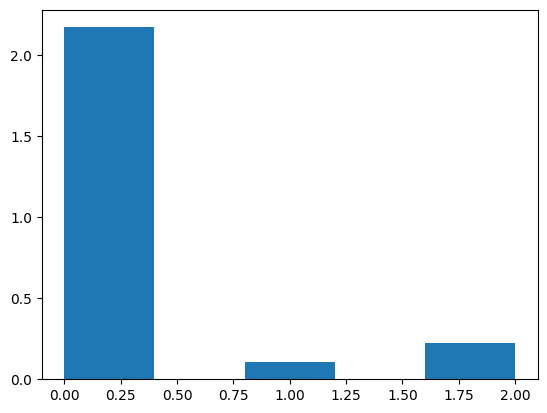

In [ ]:
plt.hist(df["lab_3"], bins=5, density=True)
plt.show()

In [ ]:
count = df['lab_b'].value_counts()
print(count)

0    2442
1     240
Name: lab_b, dtype: int64


## Data Cleaning

In [ ]:
! pip install stop-words
from stop_words import get_stop_words

stop = get_stop_words('italian')
exclusions = '|'.join(stop)

import re
def processSentence(sen):
    # To lowercase
    sen = sen.lower()
    
    # Remove Punctuation and split 's, 't, 've with a space for filter
    sen = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#)|(\w+:\/\/\S+)|(\S*\d\S*)|([,;.?!:])",
                                           " ", sen).split())
    # Remove words with 2 or fewer letters
    sen = re.sub(r'\b\w{1,3}\b', '', sen)
    # Remove whitespace (including new line characters)
    sen = re.sub(r'\s\s+', ' ', sen)
    sen = re.sub(exclusions, '', sen)
   
    
    return sen
df['sen'] = df['sentence'].apply(processSentence)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32897 sha256=36e6abc8f360b3c29deab6303592c5ebc924628981ffdf6f08978f466c509ea9
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


## Train Models 

In [ ]:
X=list(df['sen'])
y=list(df['lab_b'])


In [ ]:
# In the first step we will split the data in training and remaining dataset
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


In [ ]:
# Convert the text to a bag-of-words representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [ ]:
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(smote_data_x, smote_data_y)

# Make predictions on the test set
y_pred = classifier.predict(X_val)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
f1=f1_score(y_val, y_pred, average='macro') #,average='macro'
print("Accuracy:", accuracy)
print("f1:", f1)

Accuracy: 0.7761194029850746
f1: 0.5592105263157895


Binary: 
Accuracy: 0.9104477611940298
f1: 0.5762845849802372

In [ ]:
os=SMOTE(random_state=0)
smote_data_x, smote_data_y=os.fit_resample(X_train, y_train)

### Logistic Regression with SMOTE


In [ ]:
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(smote_data_x, smote_data_y)

# Make predictions on the test set
y_pred = classifier.predict(X_val)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
f1=f1_score(y_val, y_pred,average='macro')
print("Accuracy:", accuracy)
print("f1:", f1)

Accuracy: 0.7089552238805971
f1: 0.4011645398900301


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic regression**
* binary: Accuracy: 0.7686567164179104
f1: 0.5348785130444519
* 3 classes : f1: 0.3645368072123449


### SVM 

In [ ]:
for i in ['linear', 'poly', 'rbf', 'sigmoid']: #try all different Kernel method
        print(f'SVM method: {i} \n')
        classifier= SVC(kernel = i, random_state = 0)
        classifier.fit(smote_data_x, smote_data_y)
        y_pred = classifier.predict(X_val)


        accuracy = accuracy_score(y_val, y_pred)
        f1=f1_score(y_val, y_pred, average='macro') #
        print(f"Accuracy of kernel {i} is: {accuracy}")
        print(f"f1 of kernel {i} is: {f1}")
       



SVM method: linear 

Accuracy of kernel linear is: 0.7985074626865671
f1 of kernel linear is: 0.5668103448275862
SVM method: poly 

Accuracy of kernel poly is: 0.417910447761194
f1 of kernel poly is: 0.3577880184331797
SVM method: rbf 

Accuracy of kernel rbf is: 0.8395522388059702
f1 of kernel rbf is: 0.4985859113257625
SVM method: sigmoid 

Accuracy of kernel sigmoid is: 0.7574626865671642
f1 of kernel sigmoid is: 0.4961677512653651


#balanced classes and binary
SVM method: linear 

Accuracy of kernel linear is: 0.8059701492537313
f1 of kernel linear is: 0.5620915032679739
SVM method: poly 

Accuracy of kernel poly is: 0.40298507462686567
f1 of kernel poly is: 0.3308364544319601
SVM method: rbf 

Accuracy of kernel rbf is: 0.8507462686567164
f1 of kernel rbf is: 0.4833236938500097
SVM method: sigmoid 

Accuracy of kernel sigmoid is: 0.7723880597014925
f1 of kernel sigmoid is: 0.5374473021531846

# balanced- 3 classes 
SVM method: linear 

Accuracy of kernel linear is: 0.7238805970149254
f1 of kernel linear is: 0.3694659071682364
SVM method: poly 

Accuracy of kernel poly is: 0.47761194029850745
f1 of kernel poly is: 0.2734074139400888
SVM method: rbf 

Accuracy of kernel rbf is: 0.8134328358208955
f1 of kernel rbf is: 0.3164419312744671
SVM method: sigmoid 

Accuracy of kernel sigmoid is: 0.6828358208955224
f1 of kernel sigmoid is: 0.3149062965576727

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2)
classifier.fit(smote_data_x, smote_data_y)
y_pred = classifier.predict(X_val)
  
accuracy = accuracy_score(y_val, y_pred)
f1=f1_score(y_val, y_pred, average='macro') #
print(f"Neighboors classifier accuracy score: {accuracy}")
print(f"f1 is: {f1}")
#spec1 = specificity(y_val, y_pred)
#print(f"Neighboors classifier specificity score: {spec1}")

Neighboors classifier accuracy score: 0.12686567164179105
f1 is: 0.12290909090909091


### Decision tree

In [ ]:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0) #,
classifier.fit(smote_data_x, smote_data_y)
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1=f1_score(y_val, y_pred, average='macro')
print(f"Decision tree accuracy score: {accuracy}")
print(f"f1 is: {f1}")

Decision tree accuracy score: 0.7388059701492538
f1 is: 0.49607822069410124


**XGBoost**

In [ ]:
classifier = xgb.XGBClassifier(random_state=42)#objective="multi:softprob", 
classifier.fit(smote_data_x, smote_data_y)
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1=f1_score(y_val, y_pred, average='macro')
print(f"accuracy score: {accuracy}")
print(f"f1 is: {f1}")

accuracy score: 0.9067164179104478
f1 is: 0.5720217183008623


In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
import pickle
classifier = XGBClassifier(tree_method='approx', max_bin=255, n_estimators=250)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(classifier, smote_data_x , smote_data_y, cv=cv, scoring='f1_macro')
print(f"F1-score: {scores.mean():.2f} (std: {scores.std():.2f})")

# Save the trained model to a file
with open('model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

F1-score: 0.95 (std: 0.01)


In [ ]:
# Load the trained model from the file
with open('model.pkl', 'rb') as f:
    classifier = pickle.load(f)

classifier.fit(smote_data_x, smote_data_y)

# Make predictions on the X_val data
y_pred = classifier.predict(X_val)

# Compute the F1-score of the predictions
f1 = f1_score(y_val, y_pred, average='macro')
print(f"f1 is: {f1}")

f1 is: 0.5082719685812469


Neighboors classifier accuracy score: 0.10074626865671642
f1 is: 0.10735647709365524